# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [5]:
path = '/Users/yuqingdai/Documents/GitHub/Stock-Erdos/scratch work/Yuqing-Data-Merge/Data/dt'


In [6]:
df= pd.read_csv(path+'/dff1.csv')
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df = df[['ds', 'y', 'fbsp','diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'per', 'une', 'rus',
       'wti', 'ppi', 'rfs', 'vix']]
df
# len(df)

,ds,y,fbsp,diff,tby,ffr,fta,eps,div,per,une,rus,wti,ppi,rfs,vix
0,2009-01-28,874.09,775.368737,98.721263,2.71,0.15,1927437.0,18.75,3.23,120.3907,7.8,473.019989,42.04,171.2,336929.0,42.35
1,2009-01-29,845.14,771.778314,73.361686,2.87,0.15,1927437.0,18.75,3.23,120.3907,7.8,453.239990,41.58,171.2,336929.0,43.33
2,2009-01-30,825.88,769.800284,56.079716,2.87,0.15,1927437.0,18.75,3.23,120.3907,7.8,443.529999,41.73,171.2,336929.0,44.96
3,2009-02-02,825.44,774.798116,50.641884,2.76,0.22,1927437.0,15.31,3.24,107.1560,8.3,449.609985,41.35,169.3,335576.0,45.40
4,2009-02-03,838.51,772.782361,65.727639,2.89,0.22,1927437.0,15.31,3.24,107.1560,8.3,452.899994,40.87,169.3,335576.0,43.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2761,2020-02-21,3337.75,3176.089345,161.660655,1.46,1.58,4171570.0,135.28,1.79,25.3952,3.5,1678.609985,53.36,196.7,525810.0,17.05
2762,2020-02-24,3225.89,3177.664932,48.225068,1.38,1.58,4171570.0,135.28,1.79,25.3952,3.5,1628.099976,51.36,196.7,525810.0,20.15
2763,2020-02-25,3128.21,3179.642531,-51.432531,1.33,1.58,4171570.0,135.28,1.79,25.3952,3.5,1571.900024,49.78,196.7,525810.0,21.95
2764,2020-02-26,3116.39,3181.017180,-64.627180,1.33,1.58,4158637.0,135.28,1.79,25.3952,3.5,1552.760010,48.67,196.7,525810.0,22.45


In [7]:
p=0.9
cutoff = len(df) - int((1-p)*len(df))
df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()

In [8]:
cutoff

2490

In [9]:
df.columns

Index(['ds', 'y', 'fbsp', 'diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'per',
       'une', 'rus', 'wti', 'ppi', 'rfs', 'vix'],
      dtype='object')

In [19]:
possible_features = ['tby', 'ffr', 'eps', 'div', 'per',
       'une',  'wti',  'vix']

In [20]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False, normalize=True, copy_X = True)
reg.fit(df_train[possible_features], df_train['diff'])



LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

In [21]:
coef = []
for i in range(len(possible_features)):
    coef.append(np.round(reg.coef_[i],5))

print(coef)

[-2.97543, 85.49224, -1.82959, 100.78544, 1.95343, 19.23596, 1.60802, -17.09997]


In [22]:
pp_test = df_test.fbsp.copy() # predicted price on testing data 
pp_train = df_train.fbsp.copy() # predicted price on training data

In [23]:
df_test1 = df_test[possible_features].copy()
df_train1 = df_train[possible_features].copy()

In [24]:
for i in range(len(possible_features)):
    pp_test += coef[i] * df_test1[df_test1.columns[i]].ravel()
    pp_train += coef[i] * df_train1[df_train1.columns[i]].ravel()

In [28]:
from sklearn.metrics import mean_squared_error as MSE
# MSE for test data
# Actual close price: df_test[:test_time].y 
# Predicted price by prophet: pred_test
# Predicted price by tuning 
mse1 = MSE(df_test.y, df_test.fbsp) #
mse2 = MSE(df_test.y, pp_test)
print(mse1,mse2)

21945.472670602005 35098.992132850464


In [29]:
# MSE for train data
mse3 = MSE(df_train.y, df_train.fbsp)
mse4 = MSE(df_train.y, pp_train)
print(mse3,mse4)

19900.480731563162 9246.203609575346


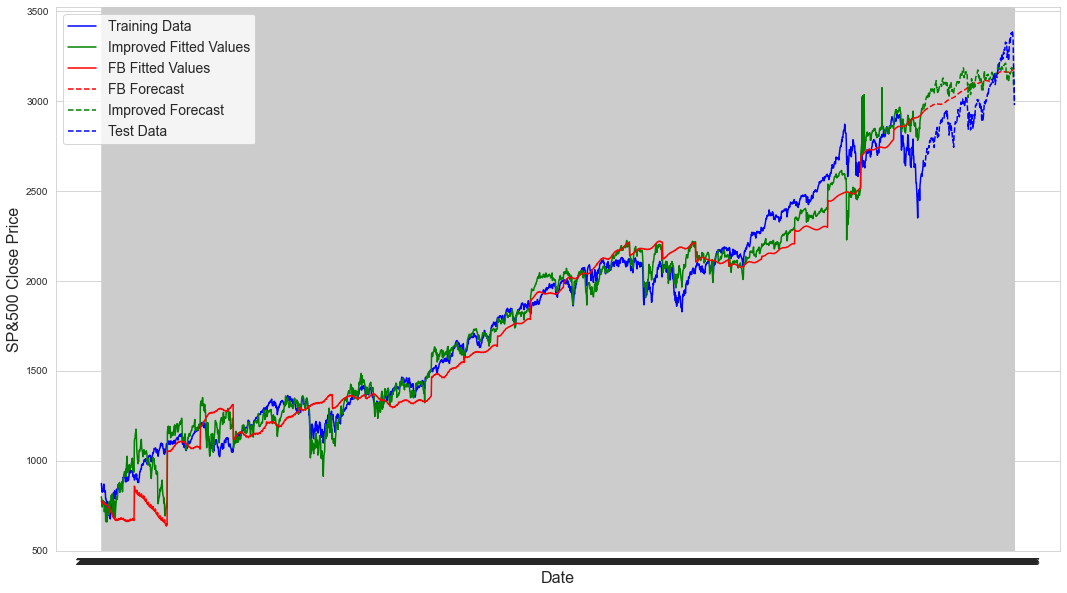

In [27]:

plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b',
            label = "Training Data")

plt.plot(df_train.ds, pp_train,'g-',
            label = "Improved Fitted Values")

# plot the fit
plt.plot(df_train.ds, df_train.fbsp,'r-',
            label = "FB Fitted Values")

# # plot the forecast
plt.plot(df_test.ds, df_test.fbsp,'r--',
            label = "FB Forecast")
plt.plot(df_test.ds, pp_test,'g--',
            label = "Improved Forecast")
plt.plot(df_test.ds,df_test.y,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()